In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import tensorflow as tf
from PIL import Image

In [18]:
style_paths = {
    'abstract': 'E://Image Datasets//Style Transfer Images//Style Images//abstract.jpg',
    'starry_night': 'E://Image Datasets//Style Transfer Images//Style Images//starry_night.jpg',
}

content_paths = {
    'golden_gate': 'E://Image Datasets//Style Transfer Images//Content Images//GoldenGate.jpg',
    'monkey': 'E://Image Datasets//Style Transfer Images//Content Images//monkey.jpg'
}

In [20]:
img_size = 512
style_path = style_paths['starry_night']
content_path = content_paths['golden_gate']
load_img = lambda path: np.array(Image.open(path).resize([img_size, img_size]))

content_img = load_img(content_path)
style_img = load_img(style_path)

In [ ]:
plt.figure(figsize = (10, 10))

plt.subplot(121)
plt.title('Content Image')
plt.imshow(content_img)
plt.axis('off')

plt.subplot(122)
plt.title('Style Image')
plt.imshow(style_img)
plt.axis('off')

plt.show()

In [4]:
preprocess_input = lambda z: tf.keras.applications.vgg19.preprocess_input(np.expand_dims(z, 0))

VGG_Bias = preprocess_input(np.zeros(3).astype('float32'))
VGG_Bias

array([[-103.939, -116.779, -123.68 ]], dtype=float32)

In [5]:
preprocessed_content_img = preprocess_input(content_img)
preprocessed_style_img = preprocess_input(style_img)

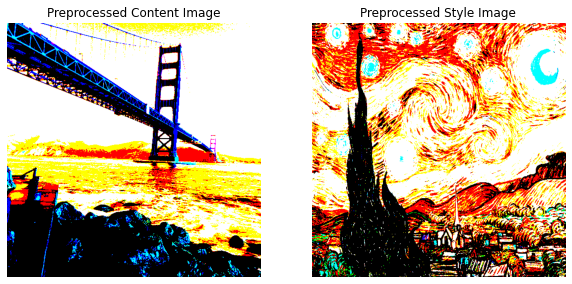

In [6]:
plt.figure(figsize = (10, 10))

plt.subplot(121)
plt.title('Preprocessed Content Image')
plt.imshow(np.clip(preprocessed_content_img[0], 0, 1));
plt.axis('off')

plt.subplot(122)
plt.title('Preprocessed Style Image')
plt.imshow(np.clip(preprocessed_style_img[0], 0, 1));
plt.axis('off')

plt.show()

In [7]:
def deprocess_input(x):
    x = np.array(x)
    x -= VGG_Bias
    
    x = np.concatenate([x[:, :, :, 2].reshape(1, img_size, img_size, 1), 
                        x[:, :, :, 1].reshape(1, img_size, img_size, 1), 
                        x[:, :, :, 0].reshape(1, img_size, img_size, 1)], axis = -1)
    return x

assert (deprocess_input(preprocess_input(content_img))[0] == content_img).all()
assert (deprocess_input(preprocess_input(style_img))[0] == style_img).all()

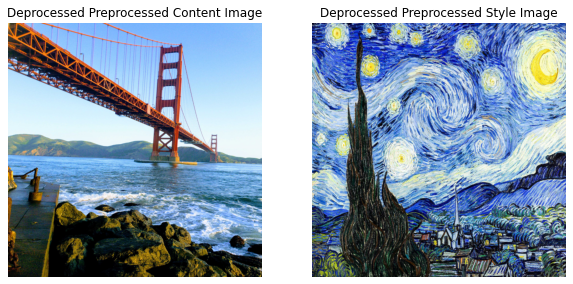

In [8]:
plt.figure(figsize = (10, 10))

plt.subplot(121)
plt.title('Deprocessed Preprocessed Content Image')
plt.imshow(deprocess_input(preprocess_input(content_img))[0].astype('uint8'))
plt.axis('off')

plt.subplot(122)
plt.title('Deprocessed Preprocessed Style Image')
plt.imshow(deprocess_input(preprocess_input(style_img))[0].astype('uint8'))
plt.axis('off')

plt.show()

In [9]:
def style_model(layers):
    base_model = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    base_model.trainable = False
    
    outs = [base_model.get_layer(layer).output for layer in layers]
    return tf.keras.models.Model(base_model.inputs, outs)

In [10]:
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
CONTENT_LAYERS = ['block5_conv2']

In [11]:
model = style_model(CONTENT_LAYERS + STYLE_LAYERS)

In [12]:
# model.layers

In [13]:
class Losses():
    def __init__(self, LAMBDA = 0.5):
        self.LAMBDA = LAMBDA
        
    def gram_matrix(self, layer):
        layer = tf.reshape(layer, (-1, layer.shape[-1]))
        gram = tf.matmul(layer, layer, transpose_a = True)
        n = gram.shape[0]
        return gram/tf.cast(n, tf.float32), n
    
    def get_content_loss(self, base_content_layer, base_out_layer):
        return tf.math.reduce_mean(tf.square(base_content_layer - base_out_layer))
    
    def get_style_loss(self, base_style_layer, base_out_layer):
        gram_style, n1 = self.gram_matrix(base_style_layer)
        gram_out, n2 = self.gram_matrix(base_out_layer)
        return tf.math.reduce_mean(tf.square(gram_style - gram_out)) / (4*(n1**2)*(n2**2))
    
    def get_total_loss(self, base_content_layers, base_style_layers, base_out_layers):
        # content loss
        base_content_layer = base_content_layers[:len(CONTENT_LAYERS)]
        base_content_out_layer = base_out_layers[:len(CONTENT_LAYERS)]
        N1 = len(base_content_layer)
        content_loss = 0
        
        for i in range(N1):
            content_loss += self.get_content_loss(base_content_layer[i], base_content_out_layer[i]) / N1
            
        # style loss
        base_style_layer = base_style_layers[len(CONTENT_LAYERS):]
        base_style_out_layer = base_out_layers[len(CONTENT_LAYERS):]
        N2 = len(base_style_layer)
        style_loss = 0
        
        for i in range(N2):
            style_loss += self.get_style_loss(base_style_layer[i], base_style_out_layer[i])
            
        # total loss
        total_loss = (self.LAMBDA * content_loss) + ((1 - self.LAMBDA) * style_loss)
        return total_loss

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate = 5, beta_1 = 0.99, epsilon = 1e-3)

In [15]:
def train(content_img, style_img, alpha, epochs = 1):
    min_val = VGG_Bias[0]
    max_val = 255 + VGG_Bias[0]

    preprocessed_content_img = preprocess_input(content_img)
    preprocessed_style_img = preprocess_input(style_img)
    out_img = tf.Variable(preprocessed_content_img + tf.random.normal(preprocessed_content_img.shape))
    
    model = style_model(CONTENT_LAYERS + STYLE_LAYERS)
    model.trainable = False

    losses = Losses(alpha)
    
    base_content = model(preprocessed_content_img)
    base_style = model(preprocessed_style_img)
    
    for e in range(epochs):

        with tf.GradientTape() as tape:
            tape.watch(out_img)
            out_layers = model(out_img)
            loss = losses.get_total_loss(base_content, base_style, out_layers)
            
        grads = tape.gradient(loss, out_img)
        opt.apply_gradients([(grads, out_img)])
        
        clipped = tf.clip_by_value(out_img, min_val, max_val)
        out_img.assign(clipped)
        
        if e%100 == 0:
            print(f'Epoch: {e} \t Loss: {loss}')
            
    return out_img

In [32]:
content_img = load_img(content_paths['golden_gate'])
style_img = load_img(style_paths['starry_night'])

out_img = train(content_img, style_img, 0.5, epochs = 501)

Epoch: 0 	 Loss: 305059.6875
Epoch: 100 	 Loss: 23097.6171875
Epoch: 200 	 Loss: 3040.032470703125
Epoch: 300 	 Loss: 1481.117431640625
Epoch: 400 	 Loss: 697.35888671875
Epoch: 500 	 Loss: 387.8037414550781


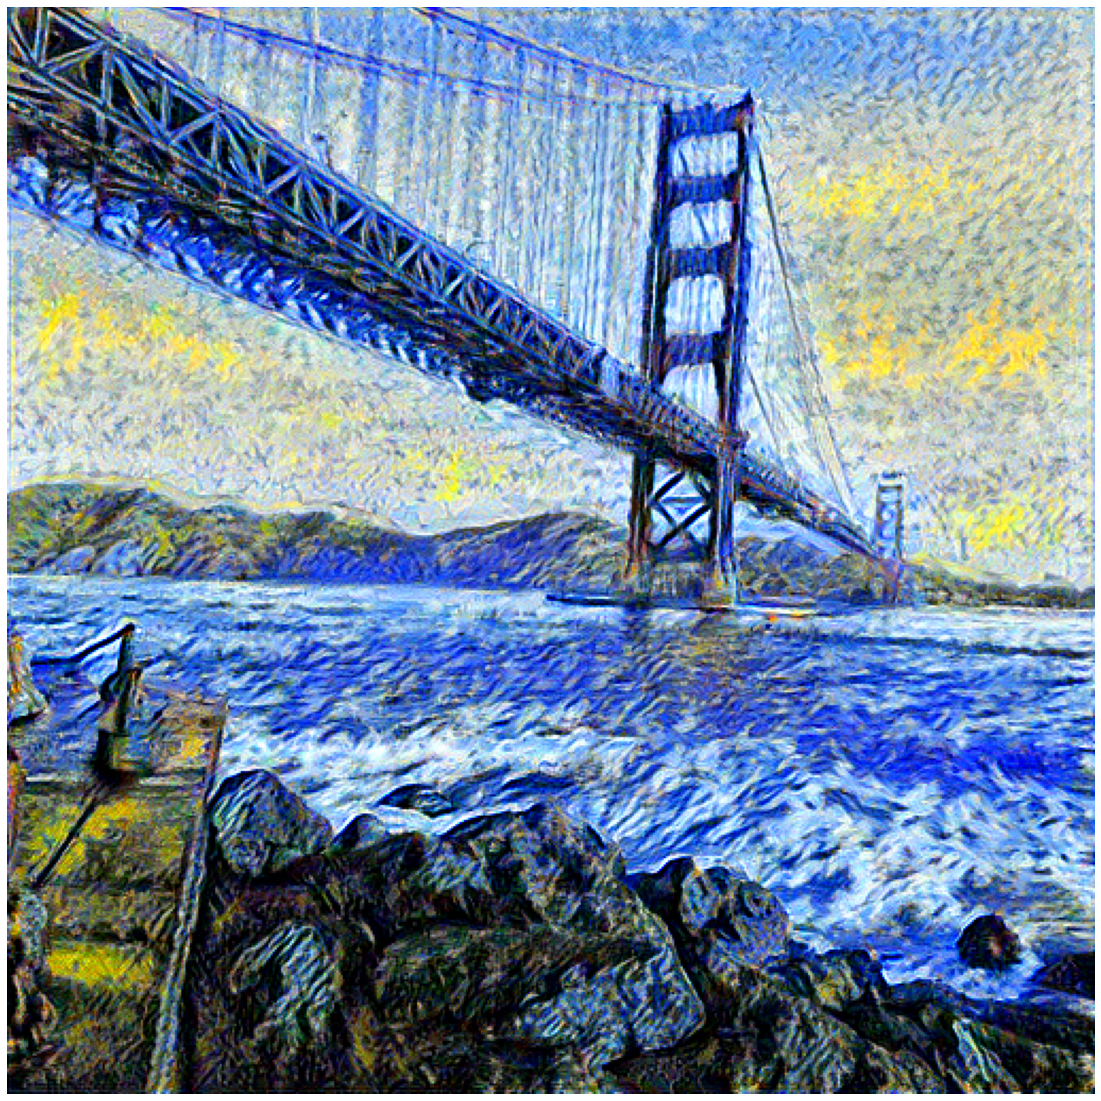

In [33]:
plt.figure(figsize = (20, 20))
plt.imshow(deprocess_input(out_img)[0].astype('uint8'))
plt.axis('off')
plt.show()